In [1]:
import random
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import csv
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.python.framework import ops
import keras.backend as K
from keras import Sequential
from keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

In [2]:
class DataGenerator():
    
    def __init__(self, datapath, itempath):
        
        '''
        Load data 
        List the users and the music items
        List all the users historic
        '''
        
        self.data  = self.load_datas(datapath, itempath)
        self.users = self.data['session_id'].unique()  #list of all users
        self.histo = self.gen_histo()
        self.train = []
        self.test  = []

    def load_music_data(self, itempath):
        
        '''
        Parameters
        ----------
        datapath :  string
                    path to the music data
        '''
        
        music = pd.read_csv(itempath, compression = 'gzip')
        music = music.rename(columns = {music.columns[0]:'track_id'})
        music = music[music.us_popularity_estimate>=95] # Focus on the song tracks that have good popularity

        return music
    
    def load_user_data(self, datapath):
        
        '''
        Parameters
        ----------
        datapath :  string
                    path to the session data
        '''
        
        user = pd.read_csv(datapath, compression = 'gzip', nrows = 100000)
        user = user.rename(columns = {user.columns[0]:'session_id'})
        
        # Correct the labeling of skip
        # rating = 1 if user doesn't the skip the music, otherwise rating = 0
        user['rating'] = user.skip_2.astype(int)*-1+1
        
        return user
    
    def load_datas(self, datapath, itempath):
        
        '''
        Load the data and merge the id of each song track. 
        A row corresponds to a rate given by a user to a song.
        '''
        
        music = self.load_music_data(itempath)
        data = self.load_user_data(datapath)
        data = pd.merge(data, music, how = 'inner', left_on = ['track_id_clean'], right_on = ['track_id'])
        data = data.groupby(['session_id','session_length']).filter(lambda x: len(x) == 20) # Filter out the sessions that are too short
        data['session_id'] = LabelEncoder().fit_transform(data['session_id'])
        data['music_id'] = LabelEncoder().fit_transform(data['track_id'])
        
        return data
    
    def gen_histo(self):
        
        '''
        Group all rates given by users and store them from older to most recent.
        
        Returns
        -------
        result :    List(DataFrame)
                    List of the historic for each user
        '''
        
        historic_users = []
        for i, u in enumerate(self.users):
            temp = self.data[self.data['session_id'] == u]
            temp = temp.sort_values('session_position').reset_index()
            temp.drop('index', axis = 1, inplace = True)
            historic_users.append(temp)
        return historic_users
    
    def sample_histo(self, user_histo, action_ratio = 0.8, max_samp_by_user = 10,  max_state = 10, max_action = 5,
                 nb_states = [], nb_actions = []):
        
        '''
        For a given historic, make one or multiple sampling.
        If no optional argument given for nb_states and nb_actions, then the sampling
        is random and each sample can have differents size for action and state.
        To normalize sampling we need to give list of the numbers of states and actions
        to be sampled.

        Parameters
        ----------
        user_histo :  DataFrame
                          historic of user
        delimiter :       string, optional
                          delimiter for the csv
        action_ratio :    float, optional
                          ratio form which song tracks in history will be selected
        max_samp_by_user: int, optional
                          Nulber max of sample to make by user
        max_state :       int, optional
                          Number max of song tracks to take for the 'state' column
        max_action :      int, optional
                          Number max of song tracks to take for the 'action' action
        nb_states :       array(int), optional
                          Numbers of song tracks to be taken for each sample made on user's historic
        nb_actions :      array(int), optional
                          Numbers of rating to be taken for each sample made on user's historic
        
        Returns
        -------
        states :         List(String)
                        All the states sampled, format of a sample: itemId&rating
        actions :        List(String)
                        All the actions sampled, format of a sample: itemId&rating
      

        Notes
        -----
        States must be before(timestamp<) the actions.
        If given, size of nb_states is the numbller of sample by user
        sizes of nb_states and nb_actions must be equals
        '''

        n = len(user_histo)
        sep = int(action_ratio * n)
        nb_sample = random.randint(1, max_samp_by_user)
        if not nb_states:
            nb_states = [min(random.randint(1, sep), max_state) for i in range(nb_sample)]
        if not nb_actions:
            nb_actions = [min(random.randint(1, n - sep), max_action) for i in range(nb_sample)]
        assert len(nb_states) == len(nb_actions), 'Given array must have the same size'
        
        states  = []
        actions = []
        # Select samples in histo 
        for i in range(len(nb_states)):
            sample_states = user_histo.iloc[0:sep].sample(nb_states[i])
            sample_actions = user_histo.iloc[-(n - sep):].sample(nb_actions[i])
            
            sample_state  = []
            sample_action = []
            for j in range(nb_states[i]):
                row = sample_states.iloc[j]
                # Formate State
                state = str(row.loc['music_id'])+'&'+str(row.loc['rating'].astype(int)) #TODO: REWARD SHAPING
                sample_state.append(state)
          
            for j in range(nb_actions[i]):
                row = sample_actions.iloc[j]
                # Formate Action 
                action = str(row.loc['music_id'])+'&'+str(row.loc['rating'].astype(int))
                sample_action.append(action)

            states.append(sample_state)
            actions.append(sample_action)
                
        return states, actions
    
    def gen_train_test(self, train_ratio, seed = None):
        
        '''
        Shuffle the historic of users and separate it in a train and a test set.
        Store the ids for each set.
        An user can't be in both set.

        Parameters
        ----------
        test_ratio :  float
                      Ratio to control the sizes of the sets
        seed       :  float
                      Seed on the shuffle
        '''
        
        n = len(self.histo)

        if seed is not None:
            random.Random(seed).shuffle(self.histo)
        else:
            random.shuffle(self.histo)

        self.train = self.histo[:int((train_ratio * n))]
        self.test  = self.histo[int((train_ratio * n)):]
        self.user_train = [h.iloc[0,0] for h in self.train]
        self.user_test  = [h.iloc[0,0] for h in self.test]
        
    def write_csv(self, filename, histo_to_write, delimiter = ';', action_ratio = 0.8, max_samp_by_user = 10,
                  max_state = 10, max_action = 5, nb_states = [], nb_actions = []):
        
        '''
        From  a given historic, create a csv file with the format:
        columns : state;action_reward;n_state
        rows    : itemid&rating1 | itemid&rating2 | ... ; itemid&rating3 | ...  | ... | item&rating4
        at filename location.

        Parameters
        ----------
        filename :        string
                          path to the file to be produced
        histo_to_write :  List(DataFrame)
                          List of the historic for each user
        delimiter :       string, optional
                          delimiter for the csv
        action_ratio :    float, optional
                          ratio form which song tracks in history will be selected
        max_samp_by_user: int, optional
                          Nulber max of sample to make by user
        max_state :       int, optional
                          Number max of song tracks to take for the 'state' column
        max_action :      int, optional
                          Number max of song tracks to take for the 'action' action
        nb_states :       array(int), optional
                          Numbers of song tracks to be taken for each sample made on user's historic
        nb_actions :      array(int), optional
                          Numbers of rating to be taken for each sample made on user's historic

        Notes
        -----
        if given, size of nb_states is the numbller of sample by user
        sizes of nb_states and nb_actions must be equals

        '''
        
        with open(filename, mode = 'w') as file:
            f_writer = csv.writer(file, delimiter = delimiter)
            f_writer.writerow(['state', 'action_reward', 'n_state'])
            for user_histo in histo_to_write:
                states, actions = self.sample_histo(user_histo, action_ratio, max_samp_by_user, max_state, max_action, nb_states, nb_actions)
                for i in range(len(states)):
                    # FORMAT STATE
                    state_str   = '|'.join(states[i])
                    # FORMAT ACTION
                    action_str  = '|'.join(actions[i])
                    # FORMAT N_STATE
                    n_state_str = state_str + '|' + action_str
                    f_writer.writerow([state_str, action_str, n_state_str])

In [3]:
class Embeddings():

    '''
    Returns Embeddings and embedding metadata after initialization with item_embeddings
    '''

    def __init__(self, item_embeddings):
        self.item_embeddings = item_embeddings
    
    def size(self):
        return self.item_embeddings.shape[1]
    
    def get_embedding_vector(self):
        return self.item_embeddings
    
    def get_embedding(self, item_index):
        return self.item_embeddings[item_index]

    def embed(self, item_list):
        return np.array([self.get_embedding(item) for item in item_list])

In [4]:
class EmbeddingsGenerator():

    '''
    Returns Embeddings after initialization with train_users and data
    '''
    
    def  __init__(self, train_users, data):
        
        self.train_users = train_users
        self.data = data.sort_values(by=['date'])
        self.session_count = self.data['session_id'].max()+1
        self.track_count = self.data['music_id'].max()+1
        self.session_tracks = {} # list of rated song tracks by each session
        for sessionId in range(self.session_count):
            self.session_tracks[sessionId] = self.data[self.data.session_id == sessionId]['music_id'].tolist()
        self.m = self.model()

    def model(self, hidden_layer_size = 300):
        
        m = Sequential()
        m.add(Dense(hidden_layer_size, input_shape = (1, self.track_count)))
        m.add(Dense(self.track_count, activation = 'softmax'))
        m.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        return m
    
    def generate_input(self, session_id):
        
        '''
        Returns a context and a target for the user_id
        context: user's history with one random song removed
        target: id of random removed song
        '''
        
        session_tracks_count = len(self.session_tracks[session_id])
        # picking random song
        random_index = np.random.randint(0, session_tracks_count-1) # -1 avoids taking the last track
        # setting target
        target = np.zeros((1, self.track_count))
        target[0][self.session_tracks[session_id][random_index]] = 1
        # setting context
        context = np.zeros((1, self.track_count))
        context[0][self.session_tracks[session_id][:random_index] + self.session_tracks[session_id][random_index+1:]] = 1
        return context, target

    def train(self, nb_epochs, batch_size = 2000):
        
        '''
        Trains the model from train_users's history
        '''
        
        for i in range(nb_epochs):
            print('%d/%d' % (i+1, nb_epochs))
            batch = [self.generate_input(session_id = np.random.choice(self.train_users)) for _ in range(batch_size)]
            X_train = np.array([b[0] for b in batch])
            y_train = np.array([b[1] for b in batch])
            self.m.fit(X_train, y_train, epochs = 1, validation_split = 0.3)

    def test(self, test_users, batch_size = 2000):
        
        '''
        Returns [loss, accuracy] on the test set
        '''
        
        print('test users', len(test_users))
        batch_test = [self.generate_input(session_id = np.random.choice(test_users)) for _ in range(batch_size)]
        X_test = np.array([b[0] for b in batch_test])
        y_test = np.array([b[1] for b in batch_test])
        return self.m.evaluate(X_test, y_test)

    def save_embeddings(self, file_name):
        
        '''
        Generates a csv file containg the vector embedding for each song
        '''
        
        inp = self.m.input                                           # input placeholder
        outputs = [layer.output for layer in self.m.layers]          # all layer outputs
        functor = K.function([inp, K.learning_phase()], outputs )    # evaluation function

        # append embeddings to vectors
        vectors = []
        for music_id in range(self.track_count):
            track = np.zeros((1, 1, self.track_count))
            track[0][0][music_id] = 1
            layer_outs = functor([track])
            vector = [str(v) for v in layer_outs[0][0][0]]
            vector = '|'.join(vector)
            vectors.append([music_id, vector])

        #saves as a csv file
        embeddings = pd.DataFrame(vectors, columns = ['music_id', 'vectors']).astype({'music_id': 'int32'})
        embeddings.to_csv(file_name, sep = ';', index = False)

In [5]:
def read_file(data_path):
    
    '''
    Load data from train_set.csv or test_set.csv
    '''

    data = pd.read_csv(data_path, sep = ';')
    for col in ['state', 'n_state', 'action_reward']:
        data[col] = [np.array([[np.int(float(k)) for k in ee.split('&')] for ee in e.split('|')]) for e in data[col]]
    for col in ['state', 'n_state']:
        data[col] = [np.array([e[0] for e in l]) for l in data[col]]

    data['action'] = [[e[0] for e in l] for l in data['action_reward']]
    data['reward'] = [tuple(e[1] for e in l) for l in data['action_reward']]
    data.drop(columns = ['action_reward'], inplace = True)

    return data

def read_embeddings(embeddings_path):
    
    '''
    Load embeddings (a vector for each item)
    '''
    
    embeddings = pd.read_csv(embeddings_path, sep = ';')

    return np.array([[np.float64(k) for k in e.split('|')] for e in embeddings['vectors']])

In [6]:
class Environment():
    
    def __init__(self, data, embeddings, alpha, gamma, fixed_length):
        
        self.embeddings = embeddings

        self.embedded_data = pd.DataFrame()
        self.embedded_data['state'] = [np.array([embeddings.get_embedding(item_id) 
                                                 for item_id in row['state']]) for _, row in data.iterrows()]
        self.embedded_data['action'] = [np.array([embeddings.get_embedding(item_id) 
                                                  for item_id in row['action']]) for _, row in data.iterrows()]
        self.embedded_data['reward'] = data['reward']

        self.alpha = alpha 
        self.gamma = gamma 
        self.fixed_length = fixed_length
        self.current_state = self.reset()
        self.groups = self.get_groups()

    def reset(self):
        
        self.init_state = self.embedded_data['state'].sample(1).values[0]
        return self.init_state

    def step(self, actions):
        
        '''
        Compute reward and update state.
        Args:
          actions: embedded chosen items.
        Returns:
          cumulated_reward: overall reward.
          current_state: updated state.
        '''

        # Compute overall reward 
        simulated_rewards, cumulated_reward = self.simulate_rewards(self.current_state.reshape((1, -1)), actions.reshape((1, -1)))

        for k in range(len(simulated_rewards)): 
            if simulated_rewards[k] > 0:
                self.current_state = np.append(self.current_state, [actions[k]], axis = 0)
                if self.fixed_length: 
                    self.current_state = np.delete(self.current_state, 0, axis = 0)

        return cumulated_reward, self.current_state

    def get_groups(self):
        
        '''
        Calculate average state/action value for each group
        '''

        groups = []
        for rewards, group in self.embedded_data.groupby(['reward']):
            size = group.shape[0]
            states = np.array(list(group['state'].values))
            actions = np.array(list(group['action'].values))
            groups.append({
                'size': size,
                'rewards': rewards, 
                'average state': (np.sum(states / np.linalg.norm(states, 2, axis = 1)[:, np.newaxis], axis = 0) / size).reshape((1, -1)), # s_x^-
                'average action': (np.sum(actions / np.linalg.norm(actions, 2, axis = 1)[:, np.newaxis], axis = 0) / size).reshape((1, -1)) # a_x^-
              })
        return groups

    def simulate_rewards(self, current_state, chosen_actions, reward_type = 'grouped cosine'):
        
        '''
        Calculate simulated rewards.
        Args:
          current_state: history, list of embedded items.
          chosen_actions: embedded chosen items.
          reward_type: from ['normal', 'grouped average', 'grouped cosine'].
        Returns:
          returned_rewards: most probable rewards.
          cumulated_reward: probability weighted rewards.
        '''

        def cosine_state_action(s_t, a_t, s_i, a_i):
            cosine_state = np.dot(s_t, s_i.T) / (np.linalg.norm(s_t, 2) * np.linalg.norm(s_i, 2))
            cosine_action = np.dot(a_t, a_i.T) / (np.linalg.norm(a_t, 2) * np.linalg.norm(a_i, 2))
            return (self.alpha * cosine_state + (1 - self.alpha) * cosine_action).reshape((1,))

        if reward_type == 'normal':
            probabilities = [cosine_state_action(current_state, chosen_actions, row['state'], row['action'])
                           for _, row in self.embedded_data.iterrows()]
        elif reward_type == 'grouped average':
            probabilities = np.array([g['size'] for g in self.groups]) *\
            [(self.alpha * (np.dot(current_state, g['average state'].T) / np.linalg.norm(current_state, 2))\
            + (1 - self.alpha) * (np.dot(chosen_actions, g['average action'].T) / np.linalg.norm(chosen_actions, 2)))
             for g in self.groups]
        elif reward_type == 'grouped cosine':
            probabilities = [cosine_state_action(current_state, chosen_actions, g['average state'], g['average action']) 
                           for g in self.groups]

        # Normalize 
        probabilities = np.array(probabilities) / sum(probabilities)

        # Get most probable rewards
        if reward_type == 'normal':
            returned_rewards = self.embedded_data.iloc[np.argmax(probabilities)]['reward']
        elif reward_type in ['grouped average', 'grouped cosine']:
            returned_rewards = self.groups[np.argmax(probabilities)]['rewards']

        def overall_reward(rewards, gamma):
            return np.sum([gamma**k * reward for k, reward in enumerate(rewards)])

        if reward_type in ['normal', 'grouped average']:
            cumulated_reward = overall_reward(returned_rewards, self.gamma)
        elif reward_type == 'grouped cosine':
            # Get probability weighted cumulated reward
            cumulated_reward = np.sum([p * overall_reward(g['rewards'], self.gamma) for p, g in zip(probabilities, self.groups)])

        return returned_rewards, cumulated_reward

In [7]:
class Actor():
    
    '''
    Policy function approximator
    '''
    
    def __init__(self, sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embedding_size, tau, learning_rate, scope = 'actor'):
        
        self.sess = sess
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.batch_size = batch_size
        self.ra_length = ra_length
        self.history_length = history_length
        self.embedding_size = embedding_size
        self.tau = tau
        self.learning_rate = learning_rate
        self.scope = scope

        with tf.variable_scope(self.scope):
            # Build Actor network
            self.action_weights, self.state, self.sequence_length = self._build_net('estimator_actor')
            self.network_params = tf.trainable_variables()

            # Build target Actor network
            self.target_action_weights, self.target_state, self.target_sequence_length = self._build_net('target_actor')
            self.target_network_params = tf.trainable_variables()[len(self.network_params):] # TODO: why sublist [len(x):]? Maybe because its equal to network_params + target_network_params

            # Initialize target network weights with network weights
            self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i]) 
                                               for i in range(len(self.target_network_params))]

            # Update target network weights 
            self.update_target_network_params = [self.target_network_params[i].assign(
            tf.multiply(self.tau, self.network_params[i]) +
            tf.multiply(1 - self.tau, self.target_network_params[i]))for i in range(len(self.target_network_params))]

            # Gradient computation from Critic's action_gradients
            self.action_gradients = tf.placeholder(tf.float32, [None, self.action_space_size])
            gradients = tf.gradients(tf.reshape(self.action_weights, [self.batch_size, self.action_space_size], name = '42'),
                                     self.network_params, self.action_gradients)
            params_gradients = list(map(lambda x: tf.div(x, self.batch_size * self.action_space_size), gradients))

            # Compute ∇_a.Q(s, a|θ^µ).∇_θ^π.f_θ^π(s)
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(zip(params_gradients, self.network_params))

    def _build_net(self, scope):
        
        '''
        Build the (target) Actor network
        '''

        def gather_last_output(data, seq_lens):
            def cli_value(x, v):
                y = tf.constant(v, shape = x.get_shape(), dtype = tf.int64)
                x = tf.cast(x, tf.int64)
                return tf.where(tf.greater(x, y), x, y)

            batch_range = tf.range(tf.cast(tf.shape(data)[0], dtype = tf.int64), dtype = tf.int64)
            tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype = tf.int64)
            indices = tf.stack([batch_range, tmp_end], axis = 1)
            return tf.gather_nd(data, indices)

        with tf.variable_scope(scope):
            # Inputs: current state, sequence_length
            # Outputs: action weights 
            state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
            state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
            sequence_length = tf.placeholder(tf.int32, [None], 'sequence_length')
            cell = tf.nn.rnn_cell.GRUCell(self.embedding_size,
                                        activation = tf.nn.relu,
                                        kernel_initializer = tf.initializers.random_normal(),
                                        bias_initializer = tf.zeros_initializer())
            outputs, _ = tf.nn.dynamic_rnn(cell, state_, dtype = tf.float32, sequence_length = sequence_length)
            last_output = gather_last_output(outputs, sequence_length) # TODO: replace by h
            x = tf.keras.layers.Dense(self.ra_length * self.embedding_size)(last_output)
            action_weights = tf.reshape(x, [-1, self.ra_length, self.embedding_size])

        return action_weights, state, sequence_length

    def train(self, state, sequence_length, action_gradients):
        
        '''
        Compute ∇_a.Q(s, a|θ^µ).∇_θ^π.f_θ^π(s)
        '''
        
        self.sess.run(self.optimizer,
                      feed_dict = {
                          self.state: state,
                          self.sequence_length: sequence_length,
                          self.action_gradients: action_gradients})

    def predict(self, state, sequence_length):
        
        return self.sess.run(self.action_weights,
                            feed_dict = {
                                self.state: state,
                                self.sequence_length: sequence_length})

    def predict_target(self, state, sequence_length):
        
        return self.sess.run(self.target_action_weights,
                            feed_dict = {
                                self.target_state: state,
                                self.target_sequence_length: sequence_length})

    def init_target_network(self):
        
        self.sess.run(self.init_target_network_params)

    def update_target_network(self):
        
        self.sess.run(self.update_target_network_params)
      
    def get_recommendation_list(self, ra_length, noisy_state, embeddings, target = False):
        
        '''
        Args:
          ra_length: length of the recommendation list.
          noisy_state: current/remembered environment state with noise.
          embeddings: Embeddings object.
          target: boolean to use Actor's network or target network.
        Returns:
          Recommendation List: list of embedded items as future actions.
        '''

        def get_score(weights, embedding, batch_size):
            
            '''
            Args:
            weights: w_t^k shape = (embedding_size,).
            embedding: e_i shape = (embedding_size,).
            Returns:
            score of the item i: score_i = w_t^k.e_i^T shape = (1,).
            '''

            ret = np.dot(weights, embedding.T)
            return ret

        batch_size = noisy_state.shape[0]

        # Generate w_t = {w_t^1, ..., w_t^K}
        method = self.predict_target if target else self.predict
        weights = method(noisy_state, [ra_length] * batch_size)

        # Score items
        scores = np.array([[[get_score(weights[i][k], embedding, batch_size)
                             for embedding in embeddings.get_embedding_vector()]
                            for k in range(ra_length)] for i in range(batch_size)])

        # return a_t
        return np.array([[embeddings.get_embedding(np.argmax(scores[i][k]))
                          for k in range(ra_length)] for i in range(batch_size)])

In [8]:
class Critic():
    
    '''
    Value function approximator
    '''
    
    def __init__(self, sess, state_space_size, action_space_size, history_length, embedding_size, tau, learning_rate, scope = 'critic'):
        self.sess = sess
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.history_length = history_length
        self.embedding_size = embedding_size
        self.tau = tau
        self.learning_rate = learning_rate
        self.scope = scope

        with tf.variable_scope(self.scope):
            # Build Critic network
            self.critic_Q_value, self.state, self.action, self.sequence_length = self._build_net('estimator_critic')
            self.network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'estimator_critic')

            # Build target Critic network
            self.target_Q_value, self.target_state, self.target_action, self.target_sequence_length = self._build_net('target_critic')
            self.target_network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'target_critic')

            # Initialize target network weights with network weights (θ^µ′ ← θ^µ)
            self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
            for i in range(len(self.target_network_params))]

            # Update target network weights (θ^µ′ ← τθ^µ + (1 − τ)θ^µ′)
            self.update_target_network_params = [self.target_network_params[i].assign(
            tf.multiply(self.tau, self.network_params[i]) +
            tf.multiply(1 - self.tau, self.target_network_params[i]))
            for i in range(len(self.target_network_params))]

            # Minimize MSE between Critic's and target Critic's outputed Q-values
            self.expected_reward = tf.placeholder(tf.float32, [None, 1])
            self.loss = tf.reduce_mean(tf.squared_difference(self.expected_reward, self.critic_Q_value))
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

            # Compute ∇_a.Q(s, a|θ^µ)
            self.action_gradients = tf.gradients(self.critic_Q_value, self.action)

    def _build_net(self, scope):

        '''
        Build the (target) Critic network
        '''

        def gather_last_output(data, seq_lens):
            def cli_value(x, v):
                y = tf.constant(v, shape = x.get_shape(), dtype = tf.int64)
                return tf.where(tf.greater(x, y), x, y)

            this_range = tf.range(tf.cast(tf.shape(seq_lens)[0], dtype = tf.int64), dtype = tf.int64)
            tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype = tf.int64)
            indices = tf.stack([this_range, tmp_end], axis = 1)
            return tf.gather_nd(data, indices)

        with tf.variable_scope(scope):
            # Inputs: current state, current action
            # Outputs: predicted Q-value
            state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
            state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
            action = tf.placeholder(tf.float32, [None, self.action_space_size], 'action')
            sequence_length = tf.placeholder(tf.int64, [None], name = 'critic_sequence_length')
            cell = tf.nn.rnn_cell.GRUCell(self.history_length,
                                        activation = tf.nn.relu,
                                        kernel_initializer = tf.initializers.random_normal(),
                                        bias_initializer = tf.zeros_initializer())
            predicted_state, _ = tf.nn.dynamic_rnn(cell, state_, dtype = tf.float32, sequence_length = sequence_length)
            predicted_state = gather_last_output(predicted_state, sequence_length)

            inputs = tf.concat([predicted_state, action], axis = -1)
            layer1 = tf.layers.Dense(32, activation = tf.nn.relu)(inputs)
            layer2 = tf.layers.Dense(16, activation = tf.nn.relu)(layer1)
            critic_Q_value = tf.layers.Dense(1)(layer2)
            return critic_Q_value, state, action, sequence_length

    def train(self, state, action, sequence_length, expected_reward):
        
        '''
        Minimize MSE between expected reward and target Critic's Q-value
        '''
        
        return self.sess.run([self.critic_Q_value, self.loss, self.optimizer],
                            feed_dict = {
                                self.state: state,
                                self.action: action,
                                self.sequence_length: sequence_length,
                                self.expected_reward: expected_reward})

    def predict(self, state, action, sequence_length):
        
        '''
        Returns Critic's predicted Q-value
        '''
        
        return self.sess.run(self.critic_Q_value,
                            feed_dict = {
                                self.state: state,
                                self.action: action,
                                self.sequence_length: sequence_length})

    def predict_target(self, state, action, sequence_length):
        
        '''
        Returns target Critic's predicted Q-value
        '''
        
        return self.sess.run(self.target_Q_value,
                            feed_dict = {
                                self.target_state: state,
                                self.target_action: action,
                                self.target_sequence_length: sequence_length})

    def get_action_gradients(self, state, action, sequence_length):
        
        '''
        Returns ∇_a.Q(s, a|θ^µ)
        '''
        
        return np.array(self.sess.run(self.action_gradients,
                            feed_dict = {
                                self.state: state,
                                self.action: action,
                                self.sequence_length: sequence_length})[0])

    def init_target_network(self):
        
        self.sess.run(self.init_target_network_params)

    def update_target_network(self):
        
        self.sess.run(self.update_target_network_params)

In [9]:
class ReplayMemory():
    
    '''
    Replay memory D in article
    '''
    
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, state, action, reward, n_state):
        self.buffer.append([state, action, reward, n_state])
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)

    def size(self):
        return len(self.buffer)

    def sample_batch(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [10]:
def experience_replay(replay_memory, batch_size, actor, critic, embeddings, ra_length, state_space_size, action_space_size, discount_factor):
    
    '''
    Experience replay.
    Args:
          replay_memory: replay memory D in article.
          batch_size: sample size.
          actor: Actor network.
          critic: Critic network.
          embeddings: Embeddings object.
          state_space_size: dimension of states.
          action_space_size: dimensions of actions.
    Returns:
          Best Q-value, loss of Critic network for printing/recording purpose.
    '''

    # Sample minibatch of N transitions (s, a, r, s′)
    samples = replay_memory.sample_batch(batch_size)
    states = np.array([s[0] for s in samples])
    actions = np.array([s[1] for s in samples])
    rewards = np.array([s[2] for s in samples])
    n_states = np.array([s[3] for s in samples]).reshape(-1, state_space_size)

    # Generate a′ by target Actor network 
    n_actions = actor.get_recommendation_list(ra_length, states, embeddings, target = True).reshape(-1, action_space_size)

    # Calculate predicted Q′(s′, a′|θ^µ′) value
    target_Q_value = critic.predict_target(n_states, n_actions, [ra_length] * batch_size)

    # Set y = r + γQ′(s′, a′|θ^µ′)'
    expected_rewards = rewards + discount_factor * target_Q_value
    
    # Update Critic by minimizing (y − Q(s, a|θ^µ))²'
    critic_Q_value, critic_loss, _ = critic.train(states, actions, [ra_length] * batch_size, expected_rewards)
    
    # Update the Actor using the sampled policy gradient'
    action_gradients = critic.get_action_gradients(states, n_actions, [ra_length] * batch_size)
    actor.train(states, [ra_length] * batch_size, action_gradients)

    # Update the Critic target networks
    critic.update_target_network()

    # Update the Actor target network'
    actor.update_target_network()

    return np.amax(critic_Q_value), critic_loss

In [11]:
class Noise():
    
    '''
    Noise for Actor predictions
    '''
    
    def __init__(self, action_space_size, mu = 0, theta = 0.5, sigma = 0.2):
        self.action_space_size = action_space_size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_space_size) * self.mu

    def get(self):
        self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.rand(self.action_space_size)
        return self.state

In [12]:
def agent_train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary, nb_rounds):

    # Set up summary operators
    def build_summaries():
        episode_reward = tf.Variable(0.)
        tf.summary.scalar('reward', episode_reward)
        episode_max_Q = tf.Variable(0.)
        tf.summary.scalar('max_Q_value', episode_max_Q)
        critic_loss = tf.Variable(0.)
        tf.summary.scalar('critic_loss', critic_loss)

        summary_vars = [episode_reward, episode_max_Q, critic_loss]
        summary_ops = tf.summary.merge_all()
        return summary_ops, summary_vars

    summary_ops, summary_vars = build_summaries()
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(filename_summary, sess.graph)

    # Initialize target network f′ and Q′'
    actor.init_target_network()
    critic.init_target_network()

    # Initialize the capacity of replay memory D'
    replay_memory = ReplayMemory(buffer_size) # Memory D 
    replay = False

    start_time = time.time()
    for i_session in range(nb_episodes): 
        session_reward = 0
        session_Q_value = 0
        session_critic_loss = 0

        states = environment.reset() # Initialize state s_0 from previous sessions
        
        if (i_session + 1) % 10 == 0: # Update average parameters every 10 episodes
            environment.groups = environment.get_groups()
          
        exploration_noise = Noise(history_length * embeddings.size())

        for t in range(nb_rounds): 
            # Transition Generating Stage
            # Select an action a_t = {a_t^1, ..., a_t^K}
            actions = actor.get_recommendation_list(
                ra_length,
                states.reshape(1, -1) + exploration_noise.get().reshape(1, -1),
                embeddings).reshape(ra_length, embeddings.size())

            # Execute action a_t and observe the reward list {r_t^1, ..., r_t^K} for each item in a_t'
            rewards, next_states = environment.step(actions)

            # 'Store transition (s_t, a_t, r_t, s_t+1) 
            replay_memory.add(states.reshape(history_length * embeddings.size()),
                              actions.reshape(ra_length * embeddings.size()),
                              [rewards],
                              next_states.reshape(history_length * embeddings.size()))

            states = next_states # Set s_t = s_t+1'

            session_reward += rewards
            
            # Parameter Updating Stage
            if replay_memory.size() >= batch_size: # Experience replay
                replay = True
                replay_Q_value, critic_loss = experience_replay(replay_memory, batch_size,
                  actor, critic, embeddings, ra_length, history_length * embeddings.size(),
                  ra_length * embeddings.size(), discount_factor)
                session_Q_value += replay_Q_value
                session_critic_loss += critic_loss

            summary_str = sess.run(summary_ops,
                                  feed_dict = {summary_vars[0]: session_reward,
                                              summary_vars[1]: session_Q_value,
                                              summary_vars[2]: session_critic_loss})
            
            writer.add_summary(summary_str, i_session)

        str_loss = str('Loss = %0.4f' % session_critic_loss)
        print(('Episode %d/%d Time = %ds ' + (str_loss if replay else 'No replay')) % (i_session + 1, nb_episodes, time.time() - start_time))
        start_time = time.time()
        
    writer.close()

In [13]:
# Hyperparameters
history_length = 10 # N in session
ra_length = 3 # K in session
discount_factor = 0.99 # Gamma in Bellman equation
actor_lr = 0.00005
critic_lr = 0.001
tau = 0.001 
batch_size = 64
nb_rounds = 50
nb_episodes = 5
filename_summary = 'summary.txt'
alpha = 0.2 
gamma = 0.9 
buffer_size = 10000 # Size of replay memory D 
fixed_length = True # Fixed memory length

In [14]:
dg = DataGenerator('../data/user_mini_data.tar.gz', '../data/music_mini_data.tar.gz')
dg.gen_train_test(train_ratio = 0.7, seed = 42)
dg.write_csv('train_set.csv', dg.train, nb_states = [history_length], nb_actions = [ra_length])
dg.write_csv('test_set.csv', dg.test, nb_states = [history_length], nb_actions = [ra_length])
data = read_file('train_set.csv')

In [15]:
if False: # Generate embeddings
    eg = EmbeddingsGenerator(dg.user_train, dg.data)
    eg.train(nb_epochs = 200)
    eg.save_embeddings('../src/embeddings.csv')

In [16]:
embeddings = Embeddings(read_embeddings('../src/embeddings.csv'))

state_space_size = embeddings.size() * history_length
action_space_size = embeddings.size() * ra_length

In [24]:
import tensorflow.compat.v1 as tf

environment = Environment(data, embeddings, alpha, gamma, fixed_length)
tf.reset_default_graph() # For multiple consecutive executions
sess = tf.Session()

tf.compat.v1.disable_eager_execution()

# Initialize actor network f_θ^π and critic network Q(s, a|θ^µ) with random weights
actor = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr)
critic = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr)
agent_train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary, nb_rounds)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Episode 1/5 Time = 9s No replay
Episode 2/5 Time = 506s Loss = 8.3892
Episode 3/5 Time = 661s Loss = 2.7190
Episode 4/5 Time = 664s Loss = 2.3052
Episode 5/5 Time = 654s Loss = 1.6668


In [25]:
dict_embeddings = {}
for i, item in enumerate(embeddings.get_embedding_vector()):
    str_item = str(item)
    assert(str_item not in dict_embeddings)
    dict_embeddings[str_item] = i

In [26]:
def state_to_items(state, actor, ra_length, embeddings, dict_embeddings, target = False):
    return [dict_embeddings[str(action)]
          for action in actor.get_recommendation_list(ra_length, np.array(state).reshape(1, -1), 
                                                      embeddings, target).reshape(ra_length, embeddings.size())]

In [27]:
music_columns = ['acousticness','beat_strength', 'bounciness', 'danceability', 
                 'energy', 'liveness', 'speechiness', 'valence']
def test_actor(actor, test_df, all_df, embeddings, dict_embeddings, ra_length, history_length, target = False, nb_rounds = 2):
    ratings = []
    unknown = 0
    diversity = []

    for _ in range(nb_rounds):
        for i in range(len(test_df)):
            history_sample = list(test_df[i].sample(history_length)['music_id'])
            recommendation = state_to_items(embeddings.embed(history_sample), actor, ra_length, embeddings, dict_embeddings, target)
            features = []
            for item in recommendation:
                l = list(test_df[i].loc[test_df[i]['music_id']==item]['rating'])
                if len(l) == 0:
                    unknown += 1
                else:
                    ratings.append(l[0])

                features.append(all_df.loc[all_df['music_id']==item][music_columns].iloc[0].tolist())

            similarity = cosine_similarity(features)
            upper_right = np.triu_indices(similarity.shape[0], k = 1)
            diversity.append(1-np.mean(similarity[upper_right]))

    return ratings, diversity

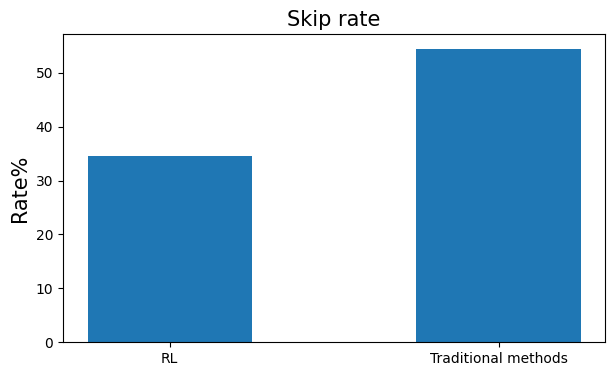

In [28]:
# Test set
ratings, diversity = test_actor(actor, dg.test, dg.data, embeddings, dict_embeddings, ra_length, history_length, target = False, nb_rounds = 2)
ratings = pd.DataFrame(ratings)

test_rating, baseline_rating = (1-ratings.mean())*100,(1-dg.data.rating.mean())*100
all_ratings = [test_rating, baseline_rating]
fig, ax = plt.subplots(figsize = (7,4))
labels = ['RL', 'Traditional methods']
x = np.arange(len(labels))
results = ax.bar(x, all_ratings, width = 0.5)
ax.set_ylabel('Rate%', fontsize = 15)
ax.set_title('Skip rate', fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()